In [1]:
#ライブラリをインポート
#標準ライブラリ
import random
import pathlib

#サードパーティー製
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import timm
import torchinfo
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision

from PIL import Image
from torchvision import models, transforms
from tqdm import tqdm
from sklearn.metrics import(
    accuracy_score,
    ConfusionMatrixDisplay, confusion_matrix

)

#自作モジュール
from utils.Module import *

#乱数シードの設定
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
print(torch.__version__)

1.13.1


In [3]:
size = 32

# 概要

SwinTransformerを使用して、果物の分類モデルを作成する．<br>
基本的にはhttps://github.com/YutaroOgawa/pytorch_advanced/blob/master/1_image_classification/1-3_transfer_learning.ipynb
からコピペしている．

## 画像群を取得

In [4]:
#訓練画像のパス
list_train_path = list(pathlib.Path("Train").iterdir())
list_train_path = [str(path) for path in list_train_path]#str化

#推論画像のパス
list_val_path = list(pathlib.Path("Val").iterdir())
list_val_path = [str(path) for path in list_val_path]#str化

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

## 適用する水増し処理

In [6]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる


class ImageTransform():
    """
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。

    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.Resize((size, size)), 
                transforms.ToTensor(),  # テンソルに変換
            ]),
            'val': transforms.Compose([
                transforms.Resize((size, size)),  # リサイズ
                transforms.ToTensor(),  # テンソルに変換
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)

## データセットを作成

In [7]:
class Dataset(data.Dataset):
    """
    アリとハチの画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'val'
        訓練か検証かを設定
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''

        # index番目の画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])
        
        # 画像のラベルをファイル名から抜き出す
        if(self.phase == "train"):
          label = list(pd.DataFrame(list_train_path).iloc[:, 0].str.split("\\", expand = True).iloc[:, -1].str.split("_", expand = True).iloc[:, 0])[index]
        else:
          label = list(pd.DataFrame(list_val_path).iloc[:, 0].str.split("\\", expand = True).iloc[:, -1].str.split("_", expand = True).iloc[:, 0])[index]


        # ラベルを数値に変更する
        if label == "apple":
            label = 0
        elif label == "tomato":
            label = 1
        elif label == "cherry":
            label = 2

        return img_transformed, label

In [8]:
# 実行
train_dataset = Dataset(
    file_list=list_train_path, transform=ImageTransform(size), phase='train')

val_dataset = Dataset(
    file_list=list_val_path, transform=ImageTransform(size), phase='val')

## DataLoaderの作成

In [9]:
# ミニバッチのサイズを指定
batch_size = 64

# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

## モデルをロード

In [10]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.cbr_1 = conv2DBatchNormRelu(
            3, 16, kernel_size=3, stride=1, padding=1, dilation=1, bias=True)
        self.cbr_2 = conv2DBatchNormRelu(
            16, 32, kernel_size=3, stride=1, padding=1, dilation=1, bias=True)
        self.se = SELayer(32)
        self.maxpool2d = nn.MaxPool2d(3, stride=2, padding=1)
        self.flatten = nn.Flatten()
        self.fc_1 = nn.Linear(32*8*8, 512)
        self.fc_2 = nn.Linear(512, 3)
        
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout1d(p=0.2, inplace=False)
        
    def forward(self, x):
        #畳み込み層
        x = self.maxpool2d(self.cbr_1(x))
        x = self.maxpool2d(self.cbr_2(x))
        x = self.se(x)
        
        #全結合層
        x = self.sigmoid(self.fc_1(self.flatten(x)))
        x = self.fc_2(self.dropout(x))
        
        return x

In [11]:
model = Model()

In [12]:
torchinfo.summary(
    model,
    input_size=(batch_size, 3, 32, 32),
    col_names=["output_size", "num_params"],
)

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [64, 3]                   --
├─conv2DBatchNormRelu: 1-1               [64, 16, 32, 32]          --
│    └─Conv2d: 2-1                       [64, 16, 32, 32]          448
│    └─BatchNorm2d: 2-2                  [64, 16, 32, 32]          32
│    └─ReLU: 2-3                         [64, 16, 32, 32]          --
│    └─Dropout2d: 2-4                    [64, 16, 32, 32]          --
├─MaxPool2d: 1-2                         [64, 16, 16, 16]          --
├─conv2DBatchNormRelu: 1-3               [64, 32, 16, 16]          --
│    └─Conv2d: 2-5                       [64, 32, 16, 16]          4,640
│    └─BatchNorm2d: 2-6                  [64, 32, 16, 16]          64
│    └─ReLU: 2-7                         [64, 32, 16, 16]          --
│    └─Dropout2d: 2-8                    [64, 32, 16, 16]          --
├─MaxPool2d: 1-4                         [64, 32, 8, 8]            --
├─SELayer: 

## 損失関数の定義

In [13]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

## 最適化手法を設定

In [14]:
# 最適化手法の設定
optimizer = optim.Adadelta(model.parameters())

## 学習と検証を実施

In [15]:
#decice = "cuda:0"
decice = "cpu"

In [16]:
# モデルを学習させる関数を作成


def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    #モデルをGPUへ
    net.to(decice)
    #lossを保存
    list_train_loss = []
    list_val_loss = []
    #正解率を保存
    list_train_acc = []
    list_val_acc = []

    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                #GPUへ
                inputs = inputs.to(decice)
                labels = labels.to(decice)
                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測
                    
  
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イタレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)  
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)
            
            #訓練の場合
            if(phase == "train"):
                list_train_loss.append(epoch_loss)
                list_train_acc.append(epoch_acc)
            #推論の場合
            else:
                list_val_loss.append(epoch_loss)
                list_val_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
    torch.save(net.state_dict(), 'model_weight.pth')
            
    return list_train_loss, list_train_acc, list_val_loss, list_val_acc

In [17]:
# 学習・検証を実行する
num_epochs=50
list_train_loss, list_train_acc, list_val_loss, list_val_acc = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.86it/s]


val Loss: 1.1001 Acc: 0.3333
Epoch 2/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.82it/s]


train Loss: 1.2976 Acc: 0.4194


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.98it/s]


val Loss: 1.0207 Acc: 0.4876
Epoch 3/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.88it/s]


train Loss: 0.9593 Acc: 0.5355


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  2.00it/s]


val Loss: 0.9220 Acc: 0.6129
Epoch 4/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.83it/s]


train Loss: 0.8909 Acc: 0.5385


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.95it/s]


val Loss: 0.9305 Acc: 0.5814
Epoch 5/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.86it/s]


train Loss: 0.8928 Acc: 0.5696


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:19<00:00,  1.72it/s]


val Loss: 0.8316 Acc: 0.6310
Epoch 6/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.90it/s]


train Loss: 0.8839 Acc: 0.5546


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.99it/s]


val Loss: 0.7443 Acc: 0.7200
Epoch 7/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.89it/s]


train Loss: 0.8531 Acc: 0.5906


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  2.00it/s]


val Loss: 0.7590 Acc: 0.6981
Epoch 8/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.77it/s]


train Loss: 0.8071 Acc: 0.5956


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.91it/s]


val Loss: 0.7369 Acc: 0.7014
Epoch 9/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.82it/s]


train Loss: 0.7990 Acc: 0.6216


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.95it/s]


val Loss: 0.7750 Acc: 0.6433
Epoch 10/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.79it/s]


train Loss: 0.8010 Acc: 0.6246


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:20<00:00,  1.61it/s]


val Loss: 0.7743 Acc: 0.6338
Epoch 11/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.82it/s]


train Loss: 0.7859 Acc: 0.6496


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:18<00:00,  1.82it/s]


val Loss: 0.6894 Acc: 0.7581
Epoch 12/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.88it/s]


train Loss: 0.7433 Acc: 0.6557


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.85it/s]


val Loss: 0.7196 Acc: 0.7119
Epoch 13/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.88it/s]


train Loss: 0.7709 Acc: 0.6366


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  2.02it/s]


val Loss: 0.8287 Acc: 0.6529
Epoch 14/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.91it/s]


train Loss: 0.7427 Acc: 0.6767


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.93it/s]


val Loss: 0.6946 Acc: 0.7290
Epoch 15/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.72it/s]


train Loss: 0.7241 Acc: 0.6727


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:19<00:00,  1.73it/s]


val Loss: 0.7631 Acc: 0.6986
Epoch 16/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.69it/s]


train Loss: 0.7225 Acc: 0.6517


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:18<00:00,  1.74it/s]


val Loss: 0.7148 Acc: 0.7376
Epoch 17/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.67it/s]


train Loss: 0.6961 Acc: 0.6927


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.97it/s]


val Loss: 0.7865 Acc: 0.6781
Epoch 18/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.85it/s]


train Loss: 0.7049 Acc: 0.6657


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  2.01it/s]


val Loss: 0.6193 Acc: 0.7586
Epoch 19/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.83it/s]


train Loss: 0.6590 Acc: 0.7087


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.08it/s]


val Loss: 0.6515 Acc: 0.7319
Epoch 20/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.99it/s]


train Loss: 0.6290 Acc: 0.7047


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.12it/s]


val Loss: 0.5783 Acc: 0.7795
Epoch 21/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.95it/s]


train Loss: 0.6441 Acc: 0.7047


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:15<00:00,  2.12it/s]


val Loss: 0.6289 Acc: 0.7443
Epoch 22/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.39it/s]


train Loss: 0.6588 Acc: 0.6947


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.84it/s]


val Loss: 0.6244 Acc: 0.7514
Epoch 23/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


train Loss: 0.6360 Acc: 0.7167


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.77it/s]


val Loss: 0.7545 Acc: 0.7014
Epoch 24/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


train Loss: 0.6260 Acc: 0.7067


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.81it/s]


val Loss: 1.0036 Acc: 0.6224
Epoch 25/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.37it/s]


train Loss: 0.6362 Acc: 0.7067


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.81it/s]


val Loss: 0.7046 Acc: 0.6943
Epoch 26/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.28it/s]


train Loss: 0.5988 Acc: 0.7327


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.82it/s]


val Loss: 0.6456 Acc: 0.7462
Epoch 27/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.27it/s]


train Loss: 0.6270 Acc: 0.7027


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:13<00:00,  2.52it/s]


val Loss: 0.7446 Acc: 0.7110
Epoch 28/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.32it/s]


train Loss: 0.5818 Acc: 0.7347


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:12<00:00,  2.63it/s]


val Loss: 0.6324 Acc: 0.7681
Epoch 29/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.37it/s]


train Loss: 0.5960 Acc: 0.6997


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:12<00:00,  2.74it/s]


val Loss: 0.7339 Acc: 0.7100
Epoch 30/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.24it/s]


train Loss: 0.5770 Acc: 0.7357


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:12<00:00,  2.63it/s]


val Loss: 0.9066 Acc: 0.6329
Epoch 31/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.86it/s]


train Loss: 0.5678 Acc: 0.7417


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.78it/s]


val Loss: 0.8554 Acc: 0.6800
Epoch 32/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.30it/s]


train Loss: 0.5568 Acc: 0.7297


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.76it/s]


val Loss: 0.8236 Acc: 0.6538
Epoch 33/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.36it/s]


train Loss: 0.5363 Acc: 0.7407


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.82it/s]


val Loss: 0.6020 Acc: 0.7743
Epoch 34/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.38it/s]


train Loss: 0.5473 Acc: 0.7487


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.80it/s]


val Loss: 0.6512 Acc: 0.7448
Epoch 35/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.37it/s]


train Loss: 0.5518 Acc: 0.7568


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.80it/s]


val Loss: 0.6535 Acc: 0.7381
Epoch 36/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.44it/s]


train Loss: 0.5563 Acc: 0.7568


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.84it/s]


val Loss: 0.6826 Acc: 0.7433
Epoch 37/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.42it/s]


train Loss: 0.5456 Acc: 0.7638


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.81it/s]


val Loss: 0.6546 Acc: 0.7438
Epoch 38/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.47it/s]


train Loss: 0.4938 Acc: 0.7648


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.78it/s]


val Loss: 0.7066 Acc: 0.7329
Epoch 39/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:06<00:00,  2.37it/s]


train Loss: 0.5654 Acc: 0.7217


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:11<00:00,  2.78it/s]


val Loss: 1.1261 Acc: 0.6195
Epoch 40/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.97it/s]


train Loss: 0.4910 Acc: 0.7648


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  2.02it/s]


val Loss: 0.6893 Acc: 0.7390
Epoch 41/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.92it/s]


train Loss: 0.5196 Acc: 0.7457


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.95it/s]


val Loss: 0.7760 Acc: 0.6843
Epoch 42/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.93it/s]


train Loss: 0.4681 Acc: 0.7798


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:18<00:00,  1.78it/s]


val Loss: 0.6995 Acc: 0.7362
Epoch 43/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:09<00:00,  1.77it/s]


train Loss: 0.4691 Acc: 0.7758


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:18<00:00,  1.76it/s]


val Loss: 0.9064 Acc: 0.6676
Epoch 44/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.97it/s]


train Loss: 0.4795 Acc: 0.7798


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  2.01it/s]


val Loss: 0.6570 Acc: 0.7538
Epoch 45/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:07<00:00,  2.03it/s]


train Loss: 0.4106 Acc: 0.8118


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.93it/s]


val Loss: 1.0550 Acc: 0.6724
Epoch 46/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.96it/s]


train Loss: 0.5079 Acc: 0.7618


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:19<00:00,  1.73it/s]


val Loss: 0.7705 Acc: 0.7229
Epoch 47/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.89it/s]


train Loss: 0.5115 Acc: 0.7558


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:18<00:00,  1.80it/s]


val Loss: 0.7728 Acc: 0.7100
Epoch 48/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.46it/s]


train Loss: 0.4481 Acc: 0.7938


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:17<00:00,  1.89it/s]


val Loss: 0.7035 Acc: 0.7410
Epoch 49/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.87it/s]


train Loss: 0.4686 Acc: 0.7828


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:18<00:00,  1.81it/s]


val Loss: 0.7462 Acc: 0.7038
Epoch 50/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.85it/s]


train Loss: 0.4208 Acc: 0.7908


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.57it/s]

val Loss: 0.6869 Acc: 0.7495


In [18]:
#訓練時のLossと正解率
df_train_loss_acc = pd.DataFrame([list_train_loss, list_train_acc, list_val_loss, list_val_acc]).T
df_train_loss_acc.columns = ["訓練Loss", "訓練精度", "推論Loss", "推論精度"]

#pickle保存
df_train_loss_acc.to_pickle("df_train_loss_acc.pkl")

In [19]:
df_train_acc = [float(train_acc.to('cpu').detach().numpy().copy()) for train_acc in list(df_train_loss_acc.loc[:, '訓練精度'].values[:-1])]
df_val_acc = [float(train_acc.to('cpu').detach().numpy().copy()) for train_acc in list(df_train_loss_acc.loc[:, '推論精度'].values)]

In [20]:
df_train_acc.append(None)
df_train_loss_acc['訓練精度'] = df_train_acc
df_train_loss_acc['推論精度'] = df_val_acc

<Figure size 640x480 with 0 Axes>

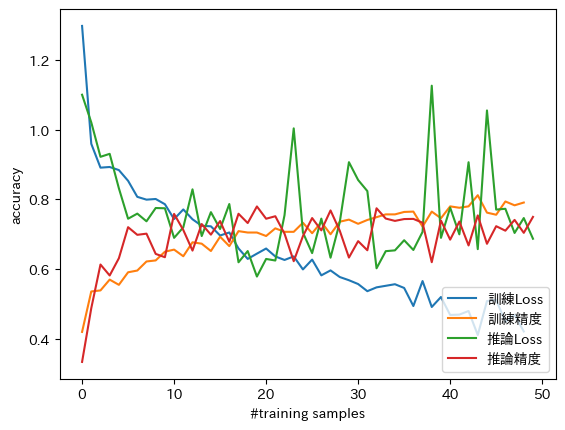

In [21]:
plt.figure()
df_train_loss_acc.plot()

plt.xlabel('#training samples')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
#plt.ylim([0, 1.01])
plt.show()

## ConfusionMatrix

In [22]:
load_weights = torch.load('model_weight.pth')
model.load_state_dict(load_weights)

<All keys matched successfully>

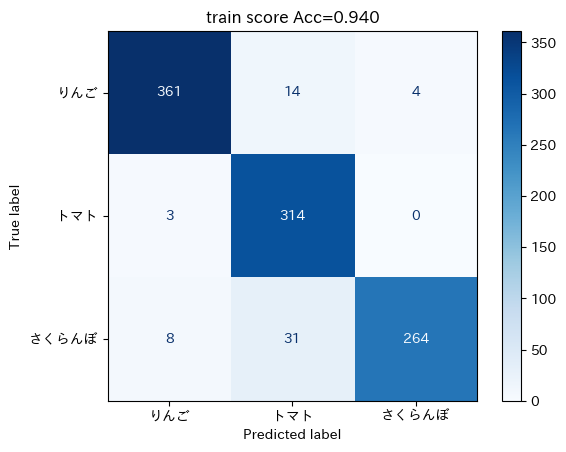

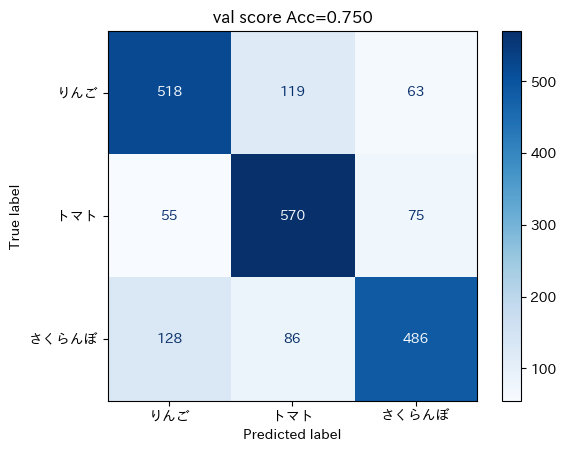

In [23]:
for phase, dataloader in dataloaders_dict.items():
  y_true = []
  y_pred = []

  for inputs, labels in dataloader:
    model.eval()
    with torch.set_grad_enabled(False):
      outputs = model.to('cpu')(inputs)
      _, preds = torch.max(outputs, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(preds.tolist())

  #スコアの計算
  accuracy = accuracy_score(y_true, y_pred)

  #混合行列
  cm = confusion_matrix(y_pred = y_pred, y_true = y_true)
  cmp = ConfusionMatrixDisplay(cm, display_labels = ["りんご", "トマト", "さくらんぼ"])
  cmp.plot(cmap = plt.cm.Blues)
  cmp.ax_.set_title(f"{phase} score Acc={accuracy:.3f}")
  plt.show()

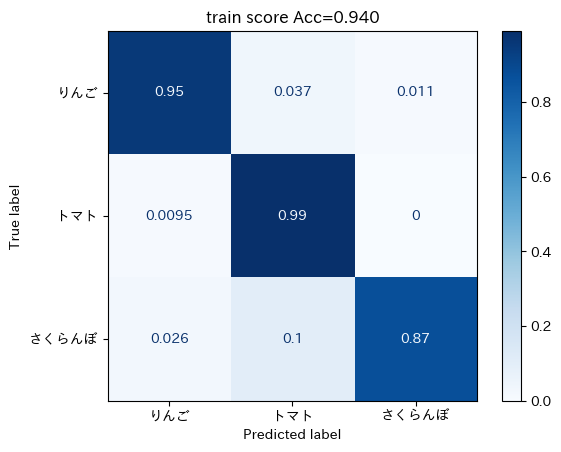

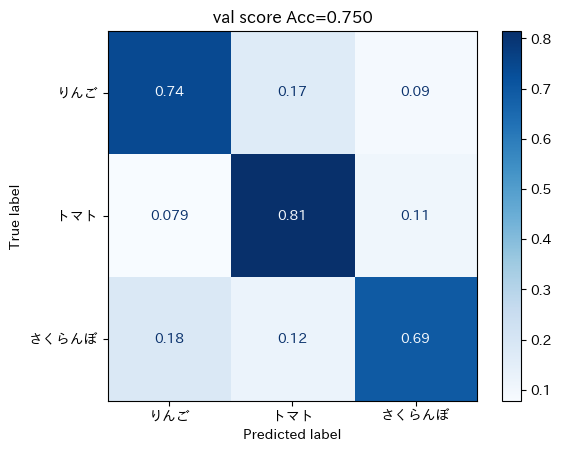

In [24]:
for phase, dataloader in dataloaders_dict.items():
  y_true = []
  y_pred = []

  for inputs, labels in dataloader:
    model.eval()
    with torch.set_grad_enabled(False):
      outputs = model.to('cpu')(inputs)
      _, preds = torch.max(outputs, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(preds.tolist())

  #スコアの計算
  accuracy = accuracy_score(y_true, y_pred)

  #混合行列
  cm = confusion_matrix(y_pred = y_pred, y_true = y_true, normalize = "true")
  cmp = ConfusionMatrixDisplay(cm, display_labels = ["りんご", "トマト", "さくらんぼ"])
  cmp.plot(cmap = plt.cm.Blues)
  cmp.ax_.set_title(f"{phase} score Acc={accuracy:.3f}")
  plt.show()